In [26]:
# Full-CI for 3*4 and 1*14

import numpy as np
import sscps
from pyscf.fci.direct_spin1 import FCISolver
from pyscf.fci.direct_spin1 import energy as fci_energy
from functools import reduce
from hf_Hubbard import HubbardMole, RHF_SpinHubbard
from simple_dmet import DMET_Outer
from dmet_hubbard import DMET_Hubbard
from pyscf.fci.direct_spin1 import absorb_h1e, contract_2e

def ovlp(h1e, eri, ci, ciinv, norb, nelec, link_index=None):
    h2e = absorb_h1e(h1e, eri, norb, nelec, .5)
    ci1 = contract_2e(h2e, ci, norb, nelec, link_index)
    return np.dot(ciinv.reshape(-1), ci1.reshape(-1))

fragments = [
    [[0], [3], [8], [11]],
    [[1], [2], [9], [10]],
    [[4], [7]],
    [[5], [6]]
]

ehf = []
efci = []
edmet = []
ecps = []
est = []

n = 12
# Scanning the occupation
for U in [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.7, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]:
    mol = HubbardMole(3, 4, 1, U)
    mol.nelectron = 12

    # Hartree Fock
    mf = RHF_SpinHubbard(mol)
    mf.kernel()
    ehf.append(mf.energy_tot())

    # Full CI
    norb = mf.mo_coeff.shape[1]
    h1e = reduce(np.dot, (mf.mo_coeff.T, mf.get_hcore(), mf.mo_coeff))
    eri = np.einsum('mi,mj,mk,ml->ijkl', mf.mo_coeff, mf.mo_coeff, mf.mo_coeff, mf.mo_coeff) * U
    nelec = (n//2, n//2)
    cis = FCISolver(mol)
    e = cis.kernel(h1e, eri, norb, nelec, davidson_only=True)[0]
    print("FCI energy = ", e)
    efci.append(e)

    # DMET
    dmet_outer = DMET_Outer(mf, fragments, dmetclass=DMET_Hubbard)
    dmet_outer.chempot_cycle()
    e = dmet_outer.inner_kernel()[0]
    print("DMET Energy = ", e)
    edmet.append(e)

    # CPS

    clm = mf.mo_coeff[:,np.argsort(mf.mo_energy)[:n//2]]   
    ci_slater = sscps.ci_slater(12, (n//2, n//2), clm)

    k = 0

    coef_fcis = []
    coef_hfs = []

    for sym_frag in fragments:
        dmet_scf = dmet_outer.dmets[k]
        cis = FCISolver(mol)
        e, coef_fci = cis.kernel(dmet_scf.get_hcore(), dmet_scf.erifb, 2, 2)
        coef_fcis.append(coef_fci)

        k +=1

    k =  0
    # dmet_outer.chempot_cycle(method="hf")
    for sym_frag in fragments:
        dmet_scf = dmet_outer.dmets[k]
        dmet_scf.rhf()

        e, c = dmet_scf.mo_energy, dmet_scf.mo_coeff
        c = c[:,np.argsort(e)[0]]
        coef_hf = np.einsum("i,j->ij", c, c)
        coef_hfs.append(coef_hf)

        k += 1

    k = 0

    ps = np.zeros((12,4))

    for sym_frag in fragments:
        proj = (coef_fcis[k] / coef_hfs[k]).reshape(-1)
        
        for frag in sym_frag:
            ps[frag[0]] = proj

        k += 1

    psinv = 1. / ps

    cinn = sscps.ci_sscps(12, (n//2, n//2), ci_slater, ps, normalized=False)
    ci = sscps.ci_sscps(12, (n//2, n//2), ci_slater, ps, normalized=True)
    ciinvnn = sscps.ci_sscps(12, (n//2, n//2), ci_slater, psinv, normalized=False)

    h1e = mf.get_hcore()
    eri = mf._eri
    e = fci_energy(h1e, eri, ci, 12, (n//2, n//2))

    print("CPS Energy = ", e)
    ecps.append(e)

    e = ovlp(h1e, eri, cinn, ciinvnn, 12, (n//2, n//2))
    print("CPS ST Energy = ", e)
    est.append(e)

ehf = np.array(ehf)
efci = np.array(efci)
edmet = np.array(edmet)
ecpsva = np.array(ecps)
ecpsst = np.array(est)


converged SCF energy = -16.6011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c739d700> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c73dd130>


FCI energy =  -16.60112615949153


Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7fe156465dc0>
Traceback (most recent call last):
  File "/home/shuoxueli/src/miniconda3/lib/python3.9/tempfile.py", line 445, in __del__
    self.close()
  File "/home/shuoxueli/src/miniconda3/lib/python3.9/tempfile.py", line 441, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/home/shuoxueli/DMET-GWF/tmpejlx5xgw'
Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7fe156465dc0>
Traceback (most recent call last):
  File "/home/shuoxueli/src/miniconda3/lib/python3.9/tempfile.py", line 445, in __del__
    self.close()
  File "/home/shuoxueli/src/miniconda3/lib/python3.9/tempfile.py", line 441, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/home/shuoxueli/DMET-GWF/tmpeelmbgra'
Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7fe156465dc0>
Traceback (most recent call last):
  File "/home/shuoxueli/src/miniconda3/

DMET Energy =  -16.601126159491532
converged SCF energy = -1.18248766685163
converged SCF energy = -1.45167009745976
converged SCF energy = -1.47054814270334
converged SCF energy = -1.56169940841965
Norm =  0.9999999999999979
Norm =  0.9999999999999979
Norm =  0.9999999999999981
CPS Energy =  -16.60112615949151
CPS ST Energy =  -16.60112615949146
converged SCF energy = -16.3011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c71a8f10> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c71a81f0>


FCI energy =  -16.303287499363247
DMET Energy =  -16.30352778894946
converged SCF energy = -1.15748833356667
converged SCF energy = -1.42664218014107
converged SCF energy = -1.44562811275806
converged SCF energy = -1.53667117680295
Norm =  0.9999999999988589
Norm =  0.9999999999988589
Norm =  1.0000945257743752
CPS Energy =  -16.30268084440201
CPS ST Energy =  -16.304223500135016
converged SCF energy = -16.0011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c71c8730> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c71c8e50>


FCI energy =  -16.009772848797894
DMET Energy =  -16.0107312464946
converged SCF energy = -1.13249014459726
converged SCF energy = -1.40156077195947
converged SCF energy = -1.42086154366024
converged SCF energy = -1.51158869682304
Norm =  0.9999999999926786
Norm =  0.9999999999926786
Norm =  1.000378049509914
CPS Energy =  -16.00734613734518
CPS ST Energy =  -16.013515444603165
converged SCF energy = -15.4011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c6fc9070> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c6fc98e0>


FCI energy =  -15.435734181228074
DMET Energy =  -15.439522225062126
converged SCF energy = -1.08249615761779
converged SCF energy = -1.35125034976646
converged SCF energy = -1.37175287557218
converged SCF energy = -1.46127322170226
Norm =  0.9999999999632441
Norm =  0.9999999999632441
Norm =  1.001511341813964
CPS Energy =  -15.426025823143773
CPS ST Energy =  -15.450682047955242
converged SCF energy = -14.8011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c730c400> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c730c850>


FCI energy =  -14.8790738071068
DMET Energy =  -14.887424421937956
converged SCF energy = -1.03250382115425
converged SCF energy = -1.30076193568861
converged SCF energy = -1.3231569055953
converged SCF energy = -1.41077509494324
Norm =  0.9999999999253286
Norm =  0.9999999999253286
Norm =  1.0033973178631235
CPS Energy =  -14.857223889584308
CPS ST Energy =  -14.912622183081803
converged SCF energy = -14.2011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c6fc9fd0> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c6fc93a0>


FCI energy =  -14.33989706249275
DMET Energy =  -14.35431300356348
converged SCF energy = -0.982511520144956
converged SCF energy = -1.25011499893721
converged SCF energy = -1.27501764021653
converged SCF energy = -1.36011315122122
Norm =  0.9999999998993306
Norm =  0.9999999998993306
Norm =  1.0060317445463112
CPS Energy =  -14.301036015860978
CPS ST Energy =  -14.399329545987552
converged SCF energy = -13.6011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c730cf10> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c730c9d0>


FCI energy =  -13.818348909145124
DMET Energy =  -13.840014522942965
converged SCF energy = -0.93251785384531
converged SCF energy = -1.19932605238999
converged SCF energy = -1.22728674396901
converged SCF energy = -1.30930352575186
Norm =  0.9999999998965983
Norm =  0.9999999998965983
Norm =  1.00940876178807
CPS Energy =  -13.75759162433216
CPS ST Energy =  -13.910795422270336
converged SCF energy = -13.0011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c6fc9550> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c6fc9880>


FCI energy =  -13.314609223255035
DMET Energy =  -13.344309025537038
converged SCF energy = -0.882521595509279
converged SCF energy = -1.14840918675076
converged SCF energy = -1.17992227210757
converged SCF energy = -1.258360115568
Norm =  0.9999999999161776
Norm =  0.9999999999161776
Norm =  1.0135209467568924
CPS Energy =  -13.227049409265824
CPS ST Energy =  -13.447008858122668
converged SCF energy = -12.4011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c730c9a0> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c730c4c0>


FCI energy =  -12.82888379185435
DMET Energy =  -12.866932657149272
converged SCF energy = -0.832521662842131
converged SCF energy = -1.09737649468047
converged SCF energy = -1.13288764762886
converged SCF energy = -1.20729495096071
Norm =  0.9999999999478298
Norm =  0.9999999999478298
Norm =  1.0183593935745179
CPS Energy =  -12.709591834274974
CPS ST Energy =  -13.007956874867663
converged SCF energy = -11.5011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c82fd5b0> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c82fdfa0>


FCI energy =  -12.134544176375764
DMET Energy =  -12.184558321110703
converged SCF energy = -0.757512804778887
converged SCF energy = -1.02063272243631
converged SCF energy = -1.06288515450852
converged SCF energy = -1.13049144029921
Norm =  0.9999999999887267
Norm =  0.9999999999887267
Norm =  1.0269559285482905
CPS Energy =  -11.95837952449261
CPS ST Energy =  -12.395723528340888
converged SCF energy = -10.6011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c70d4730> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c70d4a00>


FCI energy =  -11.481875713772379
DMET Energy =  -11.541547574768927
converged SCF energy = -0.682490743212266
converged SCF energy = -0.943681107702731
converged SCF energy = -0.993461161054267
converged SCF energy = -1.05346718932395
Norm =  0.9999999999999944
Norm =  0.9999999999999944
Norm =  1.0371230363968598
CPS Energy =  -11.237771129650904
CPS ST Energy =  -11.839053477698336
converged SCF energy = -7.60112615949154


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c720c700> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c720ceb0>


FCI energy =  -9.607604038234019
DMET Energy =  -9.66429453859668
converged SCF energy = -0.432294631419993
converged SCF energy = -0.68595543144783
converged SCF energy = -0.765326635412337
converged SCF energy = -0.795413852264488
Norm =  1.000000000889409
Norm =  1.000000000889409
Norm =  1.0817367651243233
CPS Energy =  -9.065323169108838
CPS ST Energy =  -10.383963049401656
converged SCF energy = -4.60112615949154


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c73c2340> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c73c25e0>


FCI energy =  -8.15810118210892
DMET Energy =  -8.150712295263968
converged SCF energy = -0.181871275161498
converged SCF energy = -0.426781334442605
converged SCF energy = -0.540836325836614
converged SCF energy = -0.535799416897133
Norm =  1.0000000109894256
Norm =  1.0000000109894256
Norm =  1.1412697805697085
CPS Energy =  -7.2572723273983275
CPS ST Energy =  -9.543120193879563
converged SCF energy = -1.60112615949154


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c720c7c0> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c720c580>


FCI energy =  -7.041842539239891
DMET Energy =  -6.938394889238886
converged SCF energy = 0.0688007522173559
converged SCF energy = -0.16653017544101
converged SCF energy = -0.318787757635572
converged SCF energy = -0.275017775310446
Norm =  1.000000046495534
Norm =  1.000000046495534
Norm =  1.2135282937634404
CPS Energy =  -5.807460100527671
CPS ST Energy =  -9.314310825408361
converged SCF energy = 1.39887384050845


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c7254a60> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c7254a00>


FCI energy =  -6.169697991653283
DMET Energy =  -5.968446051040399
converged SCF energy = 0.319716068792648
converged SCF energy = 0.0945533483411738
converged SCF energy = -0.098439800596851
converged SCF energy = -0.0133315405813914
Norm =  1.0000001226796682
Norm =  1.0000001226796682
Norm =  1.296386077239907
CPS Energy =  -4.682285635692608
CPS ST Energy =  -9.695863420824226
converged SCF energy = 4.39887384050846


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c720c430> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c720c940>


FCI energy =  -5.475620849474664
DMET Energy =  -5.18990708120959
converged SCF energy = 0.57085213776477
converged SCF energy = 0.356292733871563
converged SCF energy = 0.120680295368654
converged SCF energy = 0.249069122734638
Norm =  1.0000002471759908
Norm =  1.0000002471759908
Norm =  1.387946076774436
CPS Energy =  -3.8286036084797908
CPS ST Energy =  -10.686714302977773
converged SCF energy = 7.39887384050846


Initialize <hf_Hubbard.HubbardMole object at 0x7fe0c7254bb0> in <hf_Hubbard.RHF_SpinHubbard object at 0x7fe0c7254880>


FCI energy =  -4.91325920905906
DMET Energy =  -4.561055177599735
converged SCF energy = 0.822177960947662
converged SCF energy = 0.618553316216443
converged SCF energy = 0.338882965900954
converged SCF energy = 0.512039134812763
Norm =  1.000000418807393
Norm =  1.000000418807393
Norm =  1.4866011747674466
CPS Energy =  -3.186998703492276
CPS ST Energy =  -12.286308044278039


In [27]:
nocc = np.linspace(0, 24, 13) / 24

import pandas as pd

ehf = ehf / 12
efci /= 12
edmet /= 12
ecpsva /= 12
ecpsst /= 12


df = pd.DataFrame()

df['U'] = np.array([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.7, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
df['HF'] = ehf
df["FCI"] = efci
df['DMET-1S'] = edmet
df['CPS-VA-1S'] = ecpsva
df['CPS-ST-1S'] = ecpsst


In [28]:
df

U        HF       FCI   DMET-1S  CPS-VA-1S  CPS-ST-1S
0   0.0 -1.383427 -1.383427 -1.383427  -1.383427  -1.383427
1   0.1 -1.358427 -1.358607 -1.358627  -1.358557  -1.358685
2   0.2 -1.333427 -1.334148 -1.334228  -1.333946  -1.334460
3   0.4 -1.283427 -1.286311 -1.286627  -1.285502  -1.287557
4   0.6 -1.233427 -1.239923 -1.240619  -1.238102  -1.242719
5   0.8 -1.183427 -1.194991 -1.196193  -1.191753  -1.199944
6   1.0 -1.133427 -1.151529 -1.153335  -1.146466  -1.159233
7   1.2 -1.083427 -1.109551 -1.112026  -1.102254  -1.120584
8   1.4 -1.033427 -1.069074 -1.072244  -1.059133  -1.083996
9   1.7 -0.958427 -1.011212 -1.015380  -0.996532  -1.032977
10  2.0 -0.883427 -0.956823 -0.961796  -0.936481  -0.986588
11  3.0 -0.633427 -0.800634 -0.805358  -0.755444  -0.865330
12  4.0 -0.383427 -0.679842 -0.679226  -0.604773  -0.795260
13  5.0 -0.133427 -0.586820 -0.578200  -0.483955  -0.776193
14  6.0  0.116573 -0.514141 -0.497371  -0.390190  -0.807989
15  7.0  0.366573 -0.456302 -0.432492  -0.319050  -0.890560
16  8.0  0.616573 -0.409438 -0.380088  -0.265583  -1.023859

In [29]:
df.to_csv("data_Hub_34_n=12.csv", index=False)

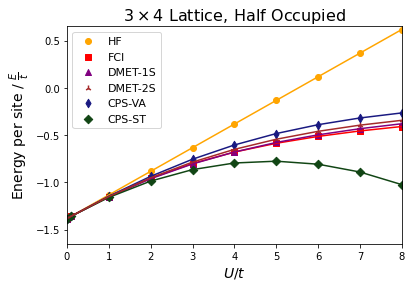

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data_Hub_34_n=12.csv")

ehf = df['HF']
efci = df['FCI']
edmet = df['DMET-1S']
ecpsva = df['CPS-VA-1S']
ecpsst = df['CPS-ST-1S']
edmet2 = df['DMET-2S']
nocc = df['U']
plt.plot(nocc, ehf, color="orange")
plt.plot(nocc, efci, color="red")
plt.plot(nocc, edmet, color="purple")
plt.plot(nocc, ecpsva, color="#191981")
plt.plot(nocc, ecpsst, color="#114514")
plt.plot(nocc, edmet2, color="brown")

plt.scatter(nocc, ehf, color="orange", label='HF')
plt.scatter(nocc, efci, color="red", marker='s', label='FCI')
plt.scatter(nocc, edmet, color="purple", marker='^', label='DMET-1S')
plt.scatter(nocc, edmet2, color="brown", marker='2', label='DMET-2S')
plt.scatter(nocc, ecpsva, color="#191981", marker='d', label='CPS-VA')
plt.scatter(nocc, ecpsst, color="#114514", marker='D', label='CPS-ST')

plt.plot()
plt.legend(fontsize=11)
#plt.xlim(0.2, 0.6)
#plt.xticks([0.2,0.3,0.4,0.5,0.6])
#plt.ylim(-1.2,-0.5)
plt.xlabel(r"$U/t$", fontsize=14)
plt.ylabel("Energy per site / " + r"$\frac{E}{t}$", fontsize=14)
plt.title(r"$3\times 4\,\,\mathrm{Lattice,\,Half\,\,Occupied}$", fontsize=16)
plt.xlim(0, 8)
plt.ylim(-1.65,0.65)
plt.show()

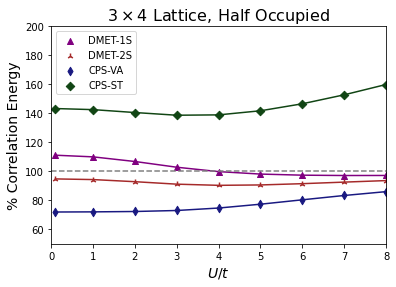

In [40]:
cdmet = (edmet-ehf)/(efci-ehf)
ccpsva = (ecpsva-ehf)/(efci-ehf)
ccpsst = (ecpsst-ehf)/(efci-ehf)
cdmet2 = (edmet2-ehf)/(efci-ehf)

plt.plot(nocc, cdmet * 100, color="purple")
plt.plot(nocc, ccpsva * 100, color="#191981")
plt.plot(nocc, ccpsst * 100, color="#114514")
plt.plot(nocc, cdmet2 * 100, color='brown')

plt.scatter(nocc, cdmet * 100, color="purple", marker='^', label='DMET-1S')
plt.scatter(nocc, cdmet2 * 100, color='brown', marker='2', label='DMET-2S')
plt.scatter(nocc, ccpsva * 100, color="#191981", marker='d', label='CPS-VA')
plt.scatter(nocc, ccpsst * 100, color="#114514", marker='D', label='CPS-ST')

plt.xlabel(r"$U/t$", fontsize=14)
plt.ylabel("% Correlation Energy", fontsize=14)
plt.legend()
plt.title(r"$3\times 4\,\,\mathrm{Lattice,\,Half\,\,Occupied}$", fontsize=16)
plt.hlines(100, 0, 8, colors='grey', linestyles="--")

plt.xlim(0, 8)
plt.ylim(50,200)
plt.show()